# Explore results after scraping results website

### User variables


In [1]:
Date = '2019-02' # yyyy-mm

### Modules and functions

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display,Image

### Load results

Load auction results and data from rdw.

In [3]:
file_name = '../data/drz-data-{}.pkl'.format(Date)
print(file_name)
drz = pd.read_pickle(file_name)
file_name = '../data/rdw-data-{}.pkl'.format(Date)
print(file_name)
rdw = pd.read_pickle(file_name)

../data/drz-data-2019-02.pkl
../data/rdw-data-2019-02.pkl


# Cheap cars with valid inspection

In [4]:
is_cheap = (
    drz.LotType == "Personenauto"
) & (
    drz.Price<3000
) & (
    drz.Price>0
) & ~(
    (
        drz.APKdate.isnull()
    ) | (
        drz.APKdate.apply(lambda x:x == '')
    )
)

drz.loc[is_cheap,
        ["Price","ItemType","ItemBrand","Mfdate","APKdate","OdoKM"]]

,Price,ItemType,ItemBrand,Mfdate,APKdate,OdoKM
2019-2-7107,1111.0,audi a2; 55 kw,AUDI,13.10.2000,08.06.2019,291.532
2019-2-7109,901.0,clk 200; coupe,MERCEDES-BENZ,15.08.1997,08.10.2019,193.127
2019-2-7118,1668.0,golf,VOLKSWAGEN,04.07.2008,20.07.2019,195.785
2019-2-7124,1689.0,polo; tdi 96 kw,VOLKSWAGEN,25.10.2005,17.04.2019,252.925
2019-2-7126,683.0,megane; gr tour 1.6 16v,RENAULT,07.10.2004,30.03.2019,249.575
2019-2-7128,1551.0,picanto; 1.0 m/t,KIA,18.06.2004,18.06.2019,130.630
2019-2-7133,1155.0,panda,FIAT,03.08.2007,01.04.2019,205.436
2019-2-7137,2226.0,tucson; 2.0 crdi aut,HYUNDAI,02.06.2006,01.06.2019,254.762
2019-2-7141,182.0,c5; 1.8i 16v,CITROËN,19.05.2001,20.07.2019,249.392
2019-2-7142,313.0,c5; 1.8i 16v,CITROËN,21.10.2004,29.05.2019,207.619


In [5]:
rdw.loc[is_cheap,["rdwinfo"]]

,rdwinfo
2019-2-7107,"{'lengte': {0: 382}, 'geluidsniveau_rijdend': ..."
2019-2-7109,"{'lengte': {0: 0}, 'wettelijk_toegestane_maxim..."
2019-2-7118,"{'lengte': {0: 0}, 'wettelijk_toegestane_maxim..."
2019-2-7124,"{'lengte': {0: 0}, 'geluidsniveau_rijdend': {0..."
2019-2-7126,"{'lengte': {0: 450}, 'geluidsniveau_rijdend': ..."
2019-2-7128,"{'lengte': {0: 350}, 'geluidsniveau_rijdend': ..."
2019-2-7133,"{'lengte': {0: 354}, 'geluidsniveau_rijdend': ..."
2019-2-7137,"{'lengte': {0: 433}, 'wettelijk_toegestane_max..."
2019-2-7141,"{'lengte': {0: 462}, 'geluidsniveau_rijdend': ..."
2019-2-7142,"{'lengte': {0: 462}, 'geluidsniveau_rijdend': ..."


In [6]:
rdw.loc[is_cheap,"rdwinfo"][0]

{'lengte': {0: 382},
 'geluidsniveau_rijdend': {0: 71},
 'wettelijk_toegestane_maximum_aslast': {0: 700, 1: 770},
 'vervaldatum_apk': {0: '08/06/2019'},
 'eerste_kleur': {0: 'GRIJS'},
 'kenteken': {0: '65GFFV'},
 'typegoedkeuringsnummer': {0: 'e1*98/14*0131*01'},
 'datum_eerste_toelating': {0: '13/10/2000'},
 'uitvoering': {0: 'FM52T008R8Z50S4K'},
 'wielbasis': {0: 240},
 'bruto_bpm': {0: 5171},
 'brandstofverbruik_buiten': {0: 4.8},
 'api_gekentekende_voertuigen_voertuigklasse': {0: 'https://opendata.rdw.nl/resource/kmfi-hrps.json'},
 'carrosserietype': {0: 'AB'},
 'api_gekentekende_voertuigen_carrosserie_specifiek': {0: 'https://opendata.rdw.nl/resource/jhie-znh9.json'},
 'co2_uitstoot_gecombineerd': {0: 146},
 'aantal_zitplaatsen': {0: 4},
 'brandstof_volgnummer': {0: 1},
 'aantal_cilinders': {0: 4},
 'type_carrosserie_europese_omschrijving': {0: 'Hatchback'},
 'aantal_wielen': {0: 4},
 'carrosserie_volgnummer': {0: 1},
 'api_gekentekende_voertuigen_assen': {0: 'https://opendata.rdw

In [7]:
pd.DataFrame(rdw.loc[is_cheap,"rdwinfo"][0]).T

,0,1
lengte,382,NaN
geluidsniveau_rijdend,71,NaN
wettelijk_toegestane_maximum_aslast,700,770
vervaldatum_apk,08/06/2019,NaN
eerste_kleur,GRIJS,NaN
kenteken,65GFFV,NaN
typegoedkeuringsnummer,e1*98/14*0131*01,NaN
datum_eerste_toelating,13/10/2000,NaN
uitvoering,FM52T008R8Z50S4K,NaN
wielbasis,240,NaN


# Pictures of lots

In [8]:
# ix=drz.N_images.idxmax()
ix=drz.Price.idxmax(); print('Price: EUR {:g}\n\n'.format(drz.loc[ix,'Price']))
# Mfdate = drz.Mfdate.apply(lambda x: pd.to_datetime(x,format='%d.%m.%Y') if len(x)==10 else pd.np.NaN)
# ix=Mfdate.idxmin(); print('year of mf: {:s}\n\n'.format(drz.loc[ix,'Mfdate']))
# ix = '2019-2-2005' # largest km/day
# ix = '2019-2-7345' # largest km

print(ix)
for u in drz.loc[ix,'Images']:
    print(u)
    print(drz.loc[ix,'Source'])
    display(Image(url=u,width=400))
    

Price: EUR 35290


2019-2-2405
http://www.domeinenrz.nl/ufc/static/1548759409/thumb/domeinenrz_sites/f34d92684bb2c7d3869a7934a3e0f5ea/1024/768/image.jpg
http://www.domeinenrz.nl/catalogus/verkoop_bij_inschrijving_2019-0002_februari?=&meerfotos=K1900022405&veilingen=2019-0002


http://www.domeinenrz.nl/ufc/static/1548759407/thumb/domeinenrz_sites/d61eb3ff6bdb8bb975e302e1ce27292b/1024/768/image.jpg
http://www.domeinenrz.nl/catalogus/verkoop_bij_inschrijving_2019-0002_februari?=&meerfotos=K1900022405&veilingen=2019-0002


http://www.domeinenrz.nl/ufc/static/1548759407/thumb/domeinenrz_sites/d70df81850af1aa7192cd4455be593e7/1024/768/image.jpg
http://www.domeinenrz.nl/catalogus/verkoop_bij_inschrijving_2019-0002_februari?=&meerfotos=K1900022405&veilingen=2019-0002


# Usage

How many km are driven per year or day?

### Odometer conversion

In [9]:
def odo_str2float(df):
    '''
    Convert odometer to numerical values.
    Also convert Miles to KMs.
    '''
    
    ml2km = 1.609344
    
    # substitute to nan
    df.OdoKM = df.OdoKM.apply(lambda x:x.replace('onbekend','nan') if (type(x) == str) and (len(x)>0) else 'nan')
    df.OdoMLS = df.OdoMLS.apply(lambda x:x.replace('onbekend','nan') if (type(x) == str) and (len(x)>0) else 'nan')
    # float
    df["OdoKM_num"] = df.OdoKM.apply(lambda x:x.replace('.','')).astype(float)
    df["OdoMLS_num"] = df.OdoMLS.apply(lambda x:x.replace('.','')).astype(float)
    # convert miles to km
    df["Odo"] = df.OdoKM_num.copy()
    chooseMls = (df.OdoKM_num.isna()) & ~(df.OdoMLS_num.isna())
    df.loc[chooseMls,"Odo"] = df.loc[chooseMls,"OdoMLS_num"].apply(float) * ml2km

In [10]:
odo_str2float(drz)

drz[['Odo','OdoKM','OdoKM_num','OdoMLS','OdoMLS_num']]

,Odo,OdoKM,OdoKM_num,OdoMLS,OdoMLS_num
2019-2-1800,1.176040e+05,117.604,117604.0,nan,NaN
2019-2-1801,1.469800e+04,14.698,14698.0,nan,NaN
2019-2-1802,NaN,nan,NaN,nan,NaN
2019-2-1804,1.969900e+04,19.699,19699.0,nan,NaN
2019-2-1805,4.184000e+03,4.184,4184.0,nan,NaN
2019-2-1806,2.391700e+04,23.917,23917.0,nan,NaN
2019-2-1808,1.751900e+04,17.519,17519.0,nan,NaN
2019-2-1809,1.571600e+04,15.716,15716.0,nan,NaN
2019-2-1810,9.584000e+03,9.584,9584.0,nan,NaN
2019-2-1811,3.475600e+04,34.756,34756.0,nan,NaN


### Dates

In [11]:
AuctDate = pd.to_datetime(drz.index[0][0:-5], format = '%Y-%m')

# serial date
drz["Mfdate_ser"] = drz.Mfdate.apply(lambda x:pd.to_datetime(x, format = '%d.%m.%Y') if x!='' else pd.np.NaN)

# age
drz["Age"] = (AuctDate - drz.Mfdate_ser)
drz["Age_year"] = drz.Age.apply(lambda x:x.days/365.25)

- - - -
# Continue with cars only

In [12]:
out = drz.Price.copy()
Features = drz.loc[:,["ItemBrand","ItemType","Odo","Age_year"]].copy()

In [13]:
# Drop rows
Subsel = drz.LotType == 'Personenauto'
dropIx=drz[~Subsel].index
out.drop(index=dropIx,inplace=True)
Features.drop(index=dropIx,inplace=True)

### one hot encoding brand and model

In [14]:
Dummies = pd.get_dummies(Features.ItemBrand,prefix='Brand_',drop_first=False)
Features = pd.concat([Features,Dummies],axis=1)

Features.describe()

,Odo,Age_year,Brand__ALFA ROMEO,Brand__AUDI,Brand__BMW,Brand__CHEVROLET,Brand__CITROËN,Brand__DACIA,Brand__DAEWOO,Brand__DAF,...,Brand__RENAULT,Brand__ROVER,Brand__SAAB,Brand__SEAT,Brand__SKODA,Brand__SMART,Brand__SUZUKI,Brand__TOYOTA,Brand__VOLKSWAGEN,Brand__VOLVO
count,173.000000,174.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,...,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000
mean,198739.551934,11.438788,0.005682,0.073864,0.079545,0.005682,0.073864,0.005682,0.005682,0.005682,...,0.045455,0.005682,0.011364,0.022727,0.011364,0.005682,0.017045,0.022727,0.170455,0.073864
std,83726.492373,5.908442,0.075378,0.262295,0.271360,0.075378,0.262295,0.075378,0.075378,0.075378,...,0.208893,0.075378,0.106295,0.149458,0.106295,0.075378,0.129810,0.149458,0.377104,0.262295
min,3314.000000,2.061602,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,149258.000000,6.292950,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,195785.000000,11.549624,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,244113.000000,14.835729,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,471916.000000,46.061602,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Plotting

In [15]:
def ecdf(data):
    x = sorted(data)
    y = pd.np.arange(0,len(x))/len(x)
    return x,y

# # example
# x,y = ecdf(km_p_day)
# plt.plot(x,y)

In [16]:
# km per day
km_p_day = Features.Odo/(Features.Age_year*365.25).fillna(0)
sel = ~(km_p_day.isna() | (km_p_day == pd.np.inf))
km_p_day = km_p_day.loc[sel]

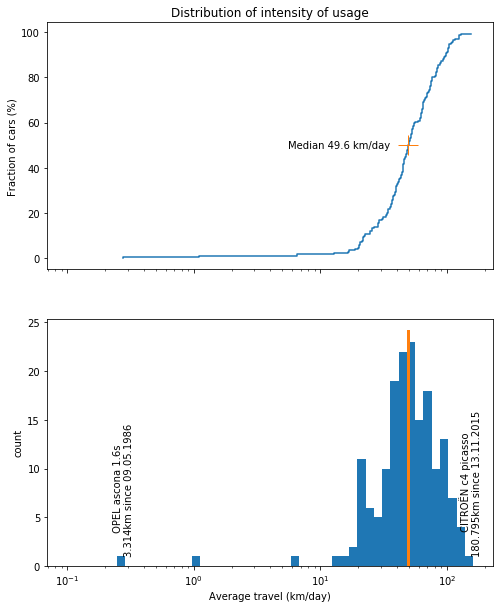

In [17]:
# Plot ecdf and hist
x,y = ecdf(km_p_day)
fig,axs = plt.subplots(ncols=1,nrows=2, figsize=[8,10],sharex=True)

# ecdf
ax = axs[0]
ax.step(x,y*100)
ax.plot(pd.np.median(x),50,'+',markersize=20)
ax.text(pd.np.median(x),50,'Median {:.1f} km/day      '.format(pd.np.median(x)),ha='right',va='center');
ax.set_title('Distribution of intensity of usage')
ax.set_ylabel('Fraction of cars (%)')

xl = axs[0].get_xlim()

# hist
ax = axs[1]
ax.hist(x,bins=pd.np.logspace(-1,pd.np.log10(xl[1]),50))
yl = axs[1].get_ylim()
ax.plot(pd.np.array([1,1])*pd.np.median(x),yl,'-',linewidth=3)
ax.set_xlabel('Average travel (km/day)')
ax.set_ylabel('count')

ax.text(
    km_p_day.min(),1,
    ' {} {}\n{}km since {}'.format(*rdw.loc[km_p_day.idxmin(),['ItemBrand','ItemType','OdoKM','Mfdate']].values),
    rotation=90,
    va='bottom',
    ha='center'
)

ax.text(
    km_p_day.max(),1,
    ' {} {}\n{}km since {}'.format(*rdw.loc[km_p_day.idxmax(),['ItemBrand','ItemType','OdoKM','Mfdate']].values),
    rotation=90,
    va='bottom',
    ha='center'
)

ax.set_xscale('log')


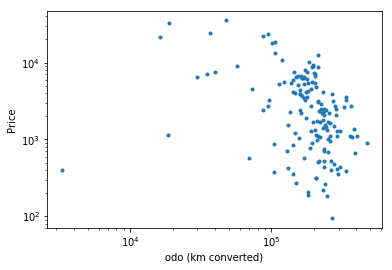

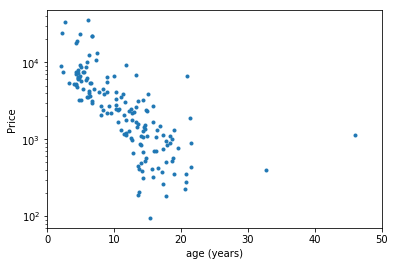

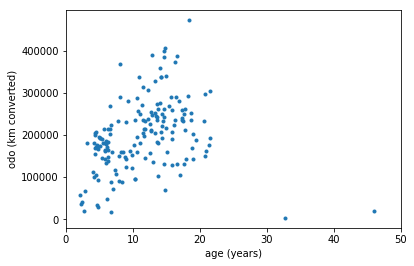

In [18]:
plt.plot(Features.Odo,out,'.')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('odo (km converted)')
plt.ylabel('Price')

plt.figure()
plt.plot(Features.Age_year,out,'.')
plt.yscale('log')
plt.xlabel('age (years)')
plt.ylabel('Price')
plt.xlim(0,50)


plt.figure()
plt.plot(Features.Age_year,Features.Odo,'.')
plt.xlabel('age (years)')
plt.ylabel('odo (km converted)')
plt.xlim(0,50)

plt.show()



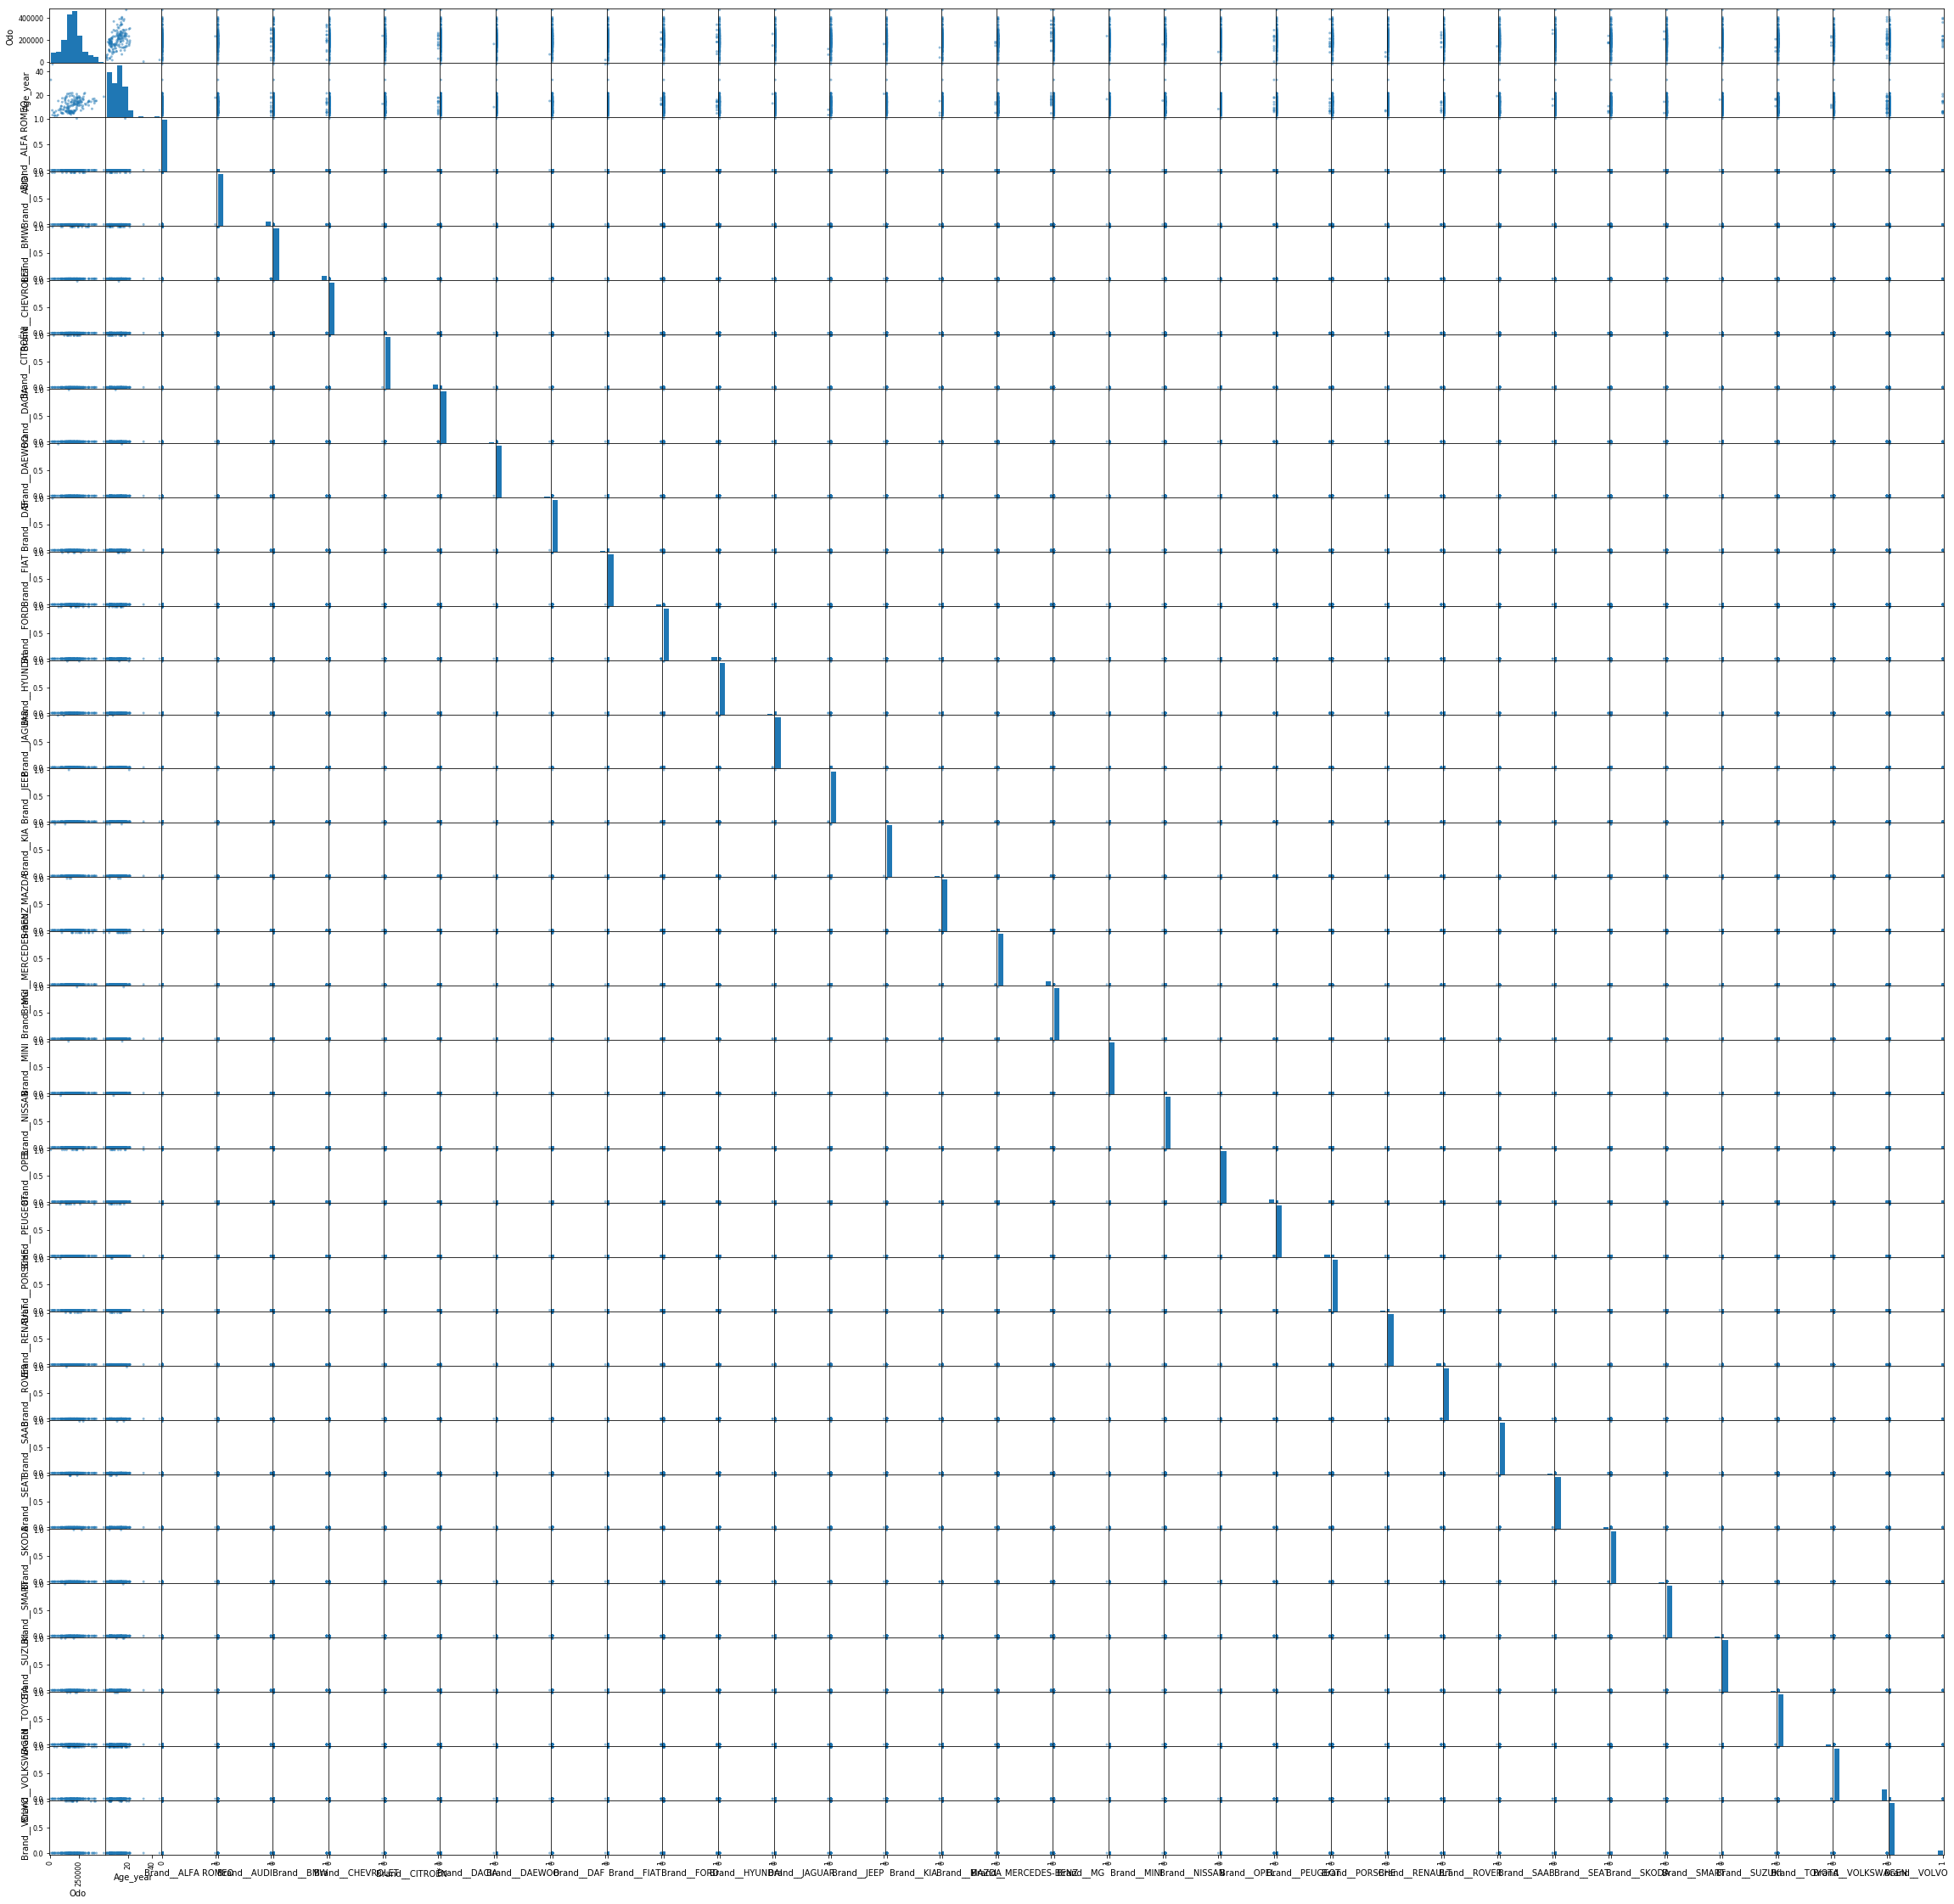

In [19]:
pd.plotting.scatter_matrix(Features,figsize=[40,40])
plt.show()